In [1]:
import datasets 
import numpy as np
import os
import time
import torch
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torchvision
import torchtext
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from langdetect import detect_langs
from torch.nn.utils.rnn import pad_sequence
from pandarallel import pandarallel 
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss

if torch.cuda.is_available():  
  use_cuda = True
else:  
  use_cuda = False

# Data Loading

In [2]:
# loading GLOVE embeddings
GLOVE = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000)  # use 10k most common words

In [3]:
# loading dataset
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()
df.describe()

Using custom data configuration ucberkeley-dlab--measuring-hate-speech-c32713cabe528196
Found cached dataset parquet (/Users/angelinazhai/.cache/huggingface/datasets/ucberkeley-dlab___parquet/ucberkeley-dlab--measuring-hate-speech-c32713cabe528196/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


In [4]:
#load numpy array from file
tmp_np_arr = np.load('hate_speech.npy', allow_pickle=True)

#convert to pandas dataframe
df.drop(df.iloc[:, 15:131], inplace=True, axis=1)
df_tmp = df.drop(["annotator_id"], axis=1)
df_norm = pd.DataFrame(tmp_np_arr, columns=df_tmp.columns)

In [5]:
df_norm

,comment_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text
0,47777,1.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,-3.9,Yes indeed. She sort of reminds me of the elde...
1,39773,0.666667,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,-6.52,The trans women reading this tweet right now i...
2,47101,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.36,Question: These 4 broads who criticize America...
3,43625,1.0,0.5,0.75,0.5,0.25,0.5,0.0,0.0,0.0,0.75,0.0,0.26,It is about time for all illegals to go back t...
4,12538,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.25,0.75,1.0,1.54,For starters bend over the one in pink and kic...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134092,37080,0.666667,0.25,0.25,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,-4.88,#___ #__ #Breaking_News |Sayyed A...
134093,22986,0.666667,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.25,0.0,-4.4,Millions of #Yemen-is participated in mass ral...
134094,21008,0.666667,0.25,0.25,0.25,0.25,0.25,0.0,0.0,0.0,0.25,0.0,-2.49,@AbeShinzo @realDonaldTrump @shinzoabe Dictat...
134095,22986,0.666667,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,-4.4,Millions of #Yemen-is participated in mass ral...


In [6]:
df_spliced = df_norm.drop('comment_id', axis=1)
df_spliced = df_spliced.drop('platform', axis=1)
df_spliced = df_spliced.drop('sentiment', axis=1)
df_spliced = df_spliced.drop('hatespeech', axis=1)
df_spliced = df_spliced.drop('hate_speech_score', axis=1)

In [7]:
df_spliced

,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,text
0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,Yes indeed. She sort of reminds me of the elde...
1,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,The trans women reading this tweet right now i...
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,Question: These 4 broads who criticize America...
3,0.75,0.5,0.25,0.5,0.0,0.0,0.0,0.75,It is about time for all illegals to go back t...
4,1.0,1.0,1.0,1.0,1.0,1.0,0.25,0.75,For starters bend over the one in pink and kic...
...,...,...,...,...,...,...,...,...,...
134092,0.25,0.0,0.0,0.5,0.0,0.0,0.0,0.5,#___ #__ #Breaking_News |Sayyed A...
134093,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.25,Millions of #Yemen-is participated in mass ral...
134094,0.25,0.25,0.25,0.25,0.0,0.0,0.0,0.25,@AbeShinzo @realDonaldTrump @shinzoabe Dictat...
134095,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,Millions of #Yemen-is participated in mass ral...


In [8]:
tweets = df_spliced.iloc[:,-1:]

In [9]:
labels = df_spliced.iloc[:,:-1]

In [10]:
labels = labels.to_numpy()

In [11]:
label_names = list(df_spliced.iloc[:,:-1].columns)

In [12]:
train_size = int(0.7*len(df_spliced))
val_size = int((len(df_spliced) - train_size)/2)
test_size = len(df_spliced) - train_size - val_size

In [13]:
train_size

93867

In [14]:
val_size

20115

In [15]:
test_size

20115

In [16]:
def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

In [51]:
def get_tweet_words(glove_vector):
    train, valid, test = [], [], []
    for index, row in df_spliced.iterrows():
        try:
            tweet = row[-1]
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_tweet(tweet)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                print(tweet)
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = np.array(row[:-1].values).astype(np.float32) 
            label = torch.tensor(label) #storing label information to tensor
            #adding tweet to corresponding train/val/test set
            if index < train_size:
                train.append((idxs, label))
            elif index < train_size+val_size:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
        except:
            print("Error at index: ", index)
            continue
    return train, valid, test


train, valid, test = get_tweet_words(glove_vector=GLOVE)

Okay taco munching beaner
@hannaranae Fucking whores
bitch edgy thot edgy
Fuckin loser fag
kys cracker
@HeXtorRose Fag ass
WhatA fucking NIGGER
@Cooper4SAE #whitesupremacist #whitenationalist #whitenativist #racist #bigot #xenophobe #islamophobe #antisemite #fuckconservatives #fuckcons #unCanadian #garbage
Jew filth whore
Edgy bitch
Tits Ass Pussy
GTFO bitch ass bitch
dumb fucking bitch
Fucking whores
Ass fucking @jockosrocket #Shemale #transsex #cdcross #matureshemale #youngshemale #cuckold @PassiValerio @Tgirlfan69 @Samuel_Verson1 @travestispix @traverbeynon @KittyTgirl @kittysilk7 @Shemaleluva87 @Jamie_Fiel @DreamTGirlz @ILoveShemaleBR @hangover08 @WorldsendNow @8QII0 URL
fucking motherfuker nigga bitch
#faggot  #twink #exposedfaggots #gayporn URL
#sissy #sissycaption #sissycaptions #sissyslut #femboy #crossdresser #feminine #sissyhypno #cock #sissygirl #boipussy #sissies #sissification URL
Disgusting thot
lmfaooo "anti white"
Kys filthy redneck twerp
*Catholicism intensifies*
RT: T

In [ ]:
#use BERT tokenizer to tokenize tweets
from transformers import BertTokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def get_tweet_words_bert(glove_vector):
    train, valid, test = [], [], []
    for index, row in df_spliced.iterrows():
        try:
            tweet = row[-1]
            idxs = tokenizer.encode(tweet, add_special_tokens=True)
            if not idxs: # ignore tweets without any word with an embedding
                print(tweet)
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = np.array(row[:-1].values).astype(np.float32) 
            label = torch.tensor(label) #storing label information to tensor
            #adding tweet to corresponding train/val/test set
            if index < train_size:
                train.append((idxs, label))
            elif index < train_size+val_size:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
        except:
            print("Error at index: ", index)
            continue
    return train, valid, test

In [18]:
# train # uncomment to see the train set

In [19]:
from torch import nn
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  y_lens = [len(y) for y in yy]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

  return xx_pad, yy_pad
  
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, collate_fn=pad_collate)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True, collate_fn=pad_collate)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True, collate_fn=pad_collate)

# Helpers

In [20]:
###############################################################################
# For Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Models

In [24]:
""" EPAI Class Models
This file contains the class objects for RNN, BiRNN, LSTM, BiLSTM and GRU.
"""
# import gensim.downloader
import torch
from torch import nn
import torchtext

# global variables
# GLOVE = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000)  # use 10k most common words
# WORD2VEC = gensim.downloader.load("word2vec-google-news-300")


class NETWORK(nn.Module):
    """
    The class object for the model network.
    Attributes:
    emb: the type of embedding
    hidden_size: the number of layers
    nn: the actual neural network
    fc: the activation layer
    """

    # param: type:str
    # param: vocab_size:int
    # param: embedding_dim:int
    # param: hidden_dim:int
    # param: output_dim:int
    # param: n_layers:int
    # param: bidirectional:bool
    # param: dropout:float
    # return: void
    # initializes the neural network with the given parameters
    def __init__(self, type, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if type == "RNN":
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif type == "GRU":
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif type == "LSTM":
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        else:
            raise Exception("Invalid RNN type")
        self.layers = n_layers
        self.fc = nn.Linear(hidden_dim*n_layers, 512)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    # param: text:torch.Tensor
    # return: torch.Tensor
    # forward pass of the neural network
    def forward(self, text):
        # embedded = self.dropout(self.embedding(text))
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        if self.layers == 1:
           hidden = self.dropout(hidden[0:,:])
        else:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        hidden = self.relu(self.fc(hidden))

        hidden = self.relu(self.fc1(hidden))
        hidden = self.relu(self.fc2(hidden))
        hidden = self.relu(self.fc3(hidden))
        hidden = self.relu(self.fc4(hidden))
        hidden = self.relu(self.fc5(hidden))
        return self.fc6(hidden.squeeze(0)) #DO NOT apply relu on the last layer; sigmoid included in logit loss


# Training

In [48]:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
          inputs= inputs.cuda()
          labels = labels.cuda()
          net = net.cuda()
        outputs = net(inputs)
        loss_func = nn.BCELoss()
        loss = loss_func(outputs, labels.float())
        loss.backward()
    return_loss = float(loss)
    return return_loss
   

def get_f1_accuracy(label, pred):
    pred = pred.detach().numpy()
    label = label.detach().numpy()
    pred = np.where(pred >= 0.6, 1, 0)
    label = np.where(label >= 0.6, 1, 0)
    return f1_score(label, pred, average='macro', zero_division=0)

# def get_val_accuracy(net, valid_loader):

#     val_acc = []
#     for text, labels in iter(valid_loader):
#         pred = net(text)
#         val_acc.append(get_f1_accuracy(labels, pred))
#     return val_acc


def train_net(net, batch_size=150, learning_rate=0.005, epochs=6):

    #initiate loaders according to batch size
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

    ########################################################################
    # Define the Loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    iters, train_loss, valid_loss, train_acc, val_acc = [], [], [], [], []
    n = 0 # the number of iterations
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(epochs):
        print(f'Epoch {epoch+1} of {epochs}')
        for text, labels in iter(train_loader):
            optimizer.zero_grad()
            output = net(text)
            train_acc.append(get_f1_accuracy(labels, output))
            loss = criterion(output, labels.squeeze())
            loss.backward()
            optimizer.step()

            #save training information
            iters.append(n)
            train_loss.append(float(loss)) 
            # calculate for validation loss
            
            n += 1
        


            # train_acc.append(get_accuracy(net, True, train_loader, valid_loader)) # compute training accuracy 
            # val_acc.append(get_accuracy(net, False, train_loader, valid_loader))  # compute validation accuracy

        # print(("Epoch {}: loss: {}, Training Accuracy: {}, Validation Accuracy: {}").format(
        #     epoch + 1, train_loss[epoch], train_acc[epoch], val_acc[epoch]
        # ))
        print("Validating...")
        # create loop for calculating for validation loss
        for text, labels in iter(valid_loader):
            val_pred = net(text)
            val_acc.append(get_f1_accuracy(labels, val_pred))
            val_loss = criterion(val_pred, labels.squeeze())
            val_loss.backward()
            valid_loss.append(float(val_loss))

        # print(("Epoch {}: Training Loss: {}, Validation Loss: {} | Training Accuracy: {}, Validation Accuracy: {}").format(
        #     epoch + 1, train_loss[epoch], val_loss[epoch], train_acc[epoch], val_acc[epoch]
        # ))
        print(("Epoch {}: loss: {}, Training Accuracy: {}").format(
            epoch + 1, train_loss[epoch], train_acc[epoch]
        ))

    # plotting; using spaghetti code for now since csv slows down training time
    print("Plotting...")
    plt.title("Loss Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    # print("Final Training Accuracy: {}".format(train_acc[-1]))
    # print("Final Validation Accuracy: {}".format(val_acc[-1]))
    # print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later
    # epochs = np.arange(1, num_epochs + 1)
    # np.savetxt("{}_train_err.csv".format(model_path), train_acc)
    # np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    # np.savetxt("{}_val_err.csv".format(model_path), val_acc)
    # np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

Epoch 1 of 3
Validating...
Epoch 1: loss: 0.7071874737739563, Training Accuracy: 0.0
Epoch 2 of 3
Validating...
Epoch 2: loss: 0.7040380239486694, Training Accuracy: 0.0
Epoch 3 of 3
Validating...
Epoch 3: loss: 0.7040957808494568, Training Accuracy: 0.0
Plotting...


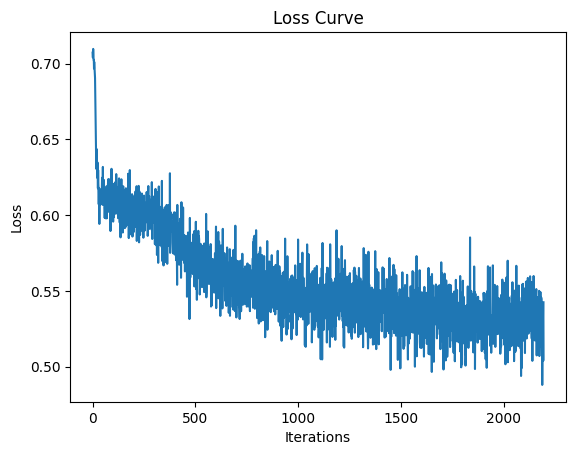

ValueError: x and y must have same first dimension, but have shapes (2193,) and (474,)

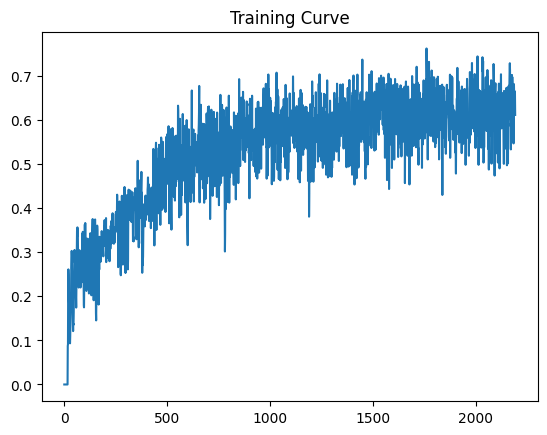

In [49]:

NETWORK_TYPE = 'LSTM' #specify the specific network type
INPUT_DIM=10000 #size of the vocabulary (number of words, arbitrary, but 10k is a good number)
EMBEDDING_DIM = 256 #size of the word embeddings
HIDDEN_DIM = 128 #size of the hidden layer
OUTPUT_DIM = 8 #size of the output layer. Fixed to 8 for this project
N_LAYERS = 2 #number of stacked RNN type layers. Please note that this is not the number of layers in the network. Only use 1 or 2 or else the network becomes too complex
BIDIRECTIONAL = True #whether to use a bidirectional network
DROPOUT = 0.35 
LEARNING_RATE = 0.00075 #learning rate for the optimizer
EPOCHS = 3 #number of epochs to train the network
BATCH_SIZE = 32 #size of the batches, which is the number of samples to be propagated through the network

#activate GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#initialize the network
model = NETWORK(NETWORK_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

#train the network
train_net(model, BATCH_SIZE, LEARNING_RATE, EPOCHS)

In [ ]:
#testing the network on the test set
def test_net(net, batch_size=150, learning_rate=0.005, epochs=6):
    #initiate loaders according to batch size
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    criterion = nn.BCEWithLogitsLoss()
    test_loss = 0
    test_acc = 0
    net.eval()
    with torch.no_grad():
        for text, labels in iter(test_loader):
            output = net(text)
            test_acc += get_accuracy(labels, output)
            loss = criterion(output, labels.squeeze())
            test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(test_loader):.3f} | Test Acc: {test_acc/len(test_loader):.2f}')